Installing libraries ...

In [ ]:
!pip install torchtext

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import pprint
import numpy as np
import pandas as pd

from sklearn import preprocessing, metrics

import torch
from torch import Tensor
from torch.utils.data import DataLoader
from torch.optim import AdamW
import torchtext
import torchtext.transforms as T
import torchtext.functional as F
from torchtext.models import RobertaClassificationHead, XLMR_BASE_ENCODER

import pickle

## 2. Data Preparation

In [ ]:
train_df = pd.read_json('stock_train.json')
test_df = pd.read_json('stock_test.json')

In [ ]:
train_df.head()

,text,label,label_id
0,"Tại thị trường trong nước, khảo sát lúc 9 giờ ...",positive,0
1,tăng 50.000 đồng/lượng ở cả hai chiều mua và b...,positive,0
2,Tại 2 thị trường lớn khác là Hà Nội và Đà Nẵng...,positive,0
3,Vàng lại bật tăng vượt ngưỡng 2.000 USD/ounce,positive,0
4,tăng 24 USD/ounce so với cùng giờ sáng qua,positive,0


In [ ]:
test_df.head()

,text,label,label_id
0,Tại 2 thị trường lớn khác là Hà Nội và Đà Nẵng...,positive,0
1,"Như vậy, trong 2 ngày qua, giá vàng nhẫn đã tă...",positive,0
2,"Giá vàng thế giới bật tăng trở lại, khi lực cầ...",positive,0
3,"Tại thị trường thế giới, thời điểm lúc 9 giờ 3...",positive,0
4,"Tuy nhiên, sau đó lực cầu bắt đáy mạnh đã giúp...",positive,0


Tokenization

In [ ]:
!pip install pyvi
from pyvi import ViTokenizer
def clean_text(text):
    text = text.lower()
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^,_' + "'`"
    for p in punctuations:
        text = text.replace(p,'')
    text = ViTokenizer.tokenize(text)
    return text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.1 MB/s eta 0:00:00


In [ ]:
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

In [ ]:
label_encoder = preprocessing.LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['label'])

In [ ]:
test_df['label'] = label_encoder.fit_transform(test_df['label'])

In [ ]:
class PadTransform(torch.nn.Module):
    """Pad tensor to a fixed length with given padding value.
    :param max_length: Maximum length to pad to
    :type max_length: int
    :param pad_value: Value to pad the tensor with
    :type pad_value: bool
    """

    def __init__(self, max_length: int, pad_value: int) -> None:
        super().__init__()
        self.max_length = max_length
        self.pad_value = float(pad_value)

    def forward(self, x: Tensor) -> Tensor:
        """
        :param x: The tensor to pad
        :type x: Tensor
        :return: Tensor padded up to max_length with pad_value
        :rtype: Tensor
        """
        max_encoded_length = x.size(-1)
        if max_encoded_length < self.max_length:
            pad_amount = self.max_length - max_encoded_length
            x = torch.nn.functional.pad(x, (0, pad_amount), value=self.pad_value)
        return x

In [ ]:
padding_idx = 1
bos_idx = 0
eos_idx = 2
max_seq_len = 256


In [ ]:
text_transform = torchtext.models.XLMR_LARGE_ENCODER.transform()


100%|██████████| 5.07M/5.07M [00:00<00:00, 87.3MB/s]
Downloading: "https://download.pytorch.org/models/text/xlmr.vocab.pt" to /root/.cache/torch/hub/checkpoints/xlmr.vocab.pt
100%|██████████| 4.85M/4.85M [00:00<00:00, 71.1MB/s]


In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return (
            torch.tensor(text_transform(self.df.iloc[idx, 0])),
            torch.tensor(self.df.iloc[idx, 1])
        )

In [ ]:
train_dataset = CustomDataset(train_df)
test_dataset = CustomDataset(test_df)


In [ ]:
SMALL_BATCH_SIZE = 16
K = 2
LARGE_BATCH_SIZE = K * SMALL_BATCH_SIZE

In [ ]:
def batch_collate_fn(batch):
    inp_list = list()
    tar_list = list()

    for sample in batch:
        inp_list.append(sample[0].tolist())
        tar_list.append(sample[1])

    padded_tensor = F.to_tensor(inp_list, padding_value=padding_idx)
    target_tensor = torch.stack(tar_list).type(torch.LongTensor)

    return padded_tensor, target_tensor


In [ ]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=SMALL_BATCH_SIZE,
    shuffle=True,
    collate_fn=batch_collate_fn
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=SMALL_BATCH_SIZE,
    shuffle=False,
    collate_fn=batch_collate_fn
)

In [ ]:
num_classes = 3
input_dim = 768

classifier_head = RobertaClassificationHead(num_classes=num_classes, input_dim=input_dim)
model = XLMR_BASE_ENCODER.get_model(head=classifier_head)

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model.to(DEVICE)
pass

learning_rate = 1.2e-5
optim = AdamW(model.parameters(), lr=learning_rate)
criteria = torch.nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/text/xlmr.base.encoder.pt" to /root/.cache/torch/hub/checkpoints/xlmr.base.encoder.pt
100%|██████████| 1.03G/1.03G [00:07<00:00, 141MB/s]


In [ ]:
def train_step(input, target, small_batch_no):
    output = model(input)
    loss = criteria(output, target)
    loss.backward()

    if (small_batch_no + 1) % K == 0 or (small_batch_no + 1) == len(train_dataloader):
        optim.step()
        optim.zero_grad()

    return loss.item() / input.size(dim=0)

def evaluate():
    model.eval()
    total_loss = 0
    counter = 0

    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            input = batch[0].clone().detach().to(DEVICE)
            output = model(input)
            target = batch[1].clone().detach().to(DEVICE)

            if i == 0:
                class_output = torch.argmax(output, dim=1)
                class_target = target
            else:
                class_output = torch.cat([class_output, torch.argmax(output, dim=1)])
                class_target = torch.cat([class_target, target])

            loss = criteria(output, target).item()
            total_loss += loss
            counter += input.size(dim=0)


        confusion_matrix = metrics.confusion_matrix(
            class_target.cpu().numpy().flatten(),
            class_output.cpu().numpy().flatten(),
            labels=[0, 1, 2]
        )
        classification_report = metrics.classification_report(
            class_target.cpu().numpy().flatten(),
            class_output.cpu().numpy().flatten(),
            labels=[0, 1, 2],
            output_dict=True
        )

    return (
        total_loss,
        counter,
        confusion_matrix,
        classification_report
    )




In [ ]:
num_epochs = 20

In [ ]:
def save_log(epoch, **kwargs):
    with open(f'log_{epoch}.pkl', 'wb') as f:
        pickle.dump(kwargs, f)

def save_model(message):
    torch.save(model.state_dict(), f'model_{message}.pth')
    print('Model saved successfully')


In [ ]:
max_accuracy = float('-inf')
max_macro_f1 = float('-inf')
max_weighted_f1 = float('-inf')


In [ ]:
for epoch in range(num_epochs):
    model.train()
    avg_training_losses = list()

    for small_batch_no, small_batch in enumerate(train_dataloader):
        input = small_batch[0].clone().detach().to(DEVICE)
        target = small_batch[1].clone().detach().to(DEVICE)
        avg_training_losses.append(
            train_step(input, target, small_batch_no)
        )
        torch.cuda.empty_cache()

    total_loss, counter, confusion_matrix, classification_report = evaluate()
    print(f'EPOCH {epoch}')
    print(f'Mean of avg_training_losses={np.mean(avg_training_losses)}')
    print(f'total_loss={total_loss}')
    print(f'counter={counter}')
    print(f'loss=total_loss/counter={total_loss/counter}')
    print(f'confusion_matrix=\n{confusion_matrix}')
    print('classification_report=')
    pprint.pprint(classification_report)

    save_log(
        epoch,
        avg_training_losses=avg_training_losses,
        total_loss=total_loss,
        counter=counter,
        loss=total_loss/counter,
        confusion_matrix=confusion_matrix,
        classification_report=classification_report
    )

    if classification_report['accuracy'] > max_accuracy:
        print(f'New max_accuracy')
        max_accuracy = classification_report['accuracy']
        max_accuracy_index = epoch
        save_model('max_accuracy')

    elif classification_report['macro avg']['f1-score'] > max_macro_f1:
        print(f'New max_macro_f1')
        max_macro_f1 = classification_report['macro avg']['f1-score']
        max_macro_f1_index = epoch
        save_model('max_macro_f1')

    elif classification_report['weighted avg']['f1-score'] > max_weighted_f1:
        print(f'New max_weighted_f1')
        max_weighted_f1 = classification_report['weighted avg']['f1-score']
        max_weighted_f1_index = epoch
        save_model('max_weighted_f1')

    elif epoch == num_epochs - 1:
        save_model(f'{epoch}_last')

    elif epoch % 40 == 0:
        save_model(f'{epoch}_checkpoint')

    else:
        continue

save_log(
    'post_train_info',
    max_accuracy=max_accuracy,
    max_accuracy_index=max_accuracy_index,
    max_macro_f1=max_macro_f1,
    max_macro_f1_index=max_macro_f1_index,
    max_weighted_f1=max_weighted_f1,
    max_weighted_f1_index=max_weighted_f1_index
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:384: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python

EPOCH 0
Mean of avg_training_losses=0.07013199135922549
total_loss=69.74248695373535
counter=1002
loss=total_loss/counter=0.06960328039294945
confusion_matrix=
[[323   0   0]
 [321   0   0]
 [358   0   0]]
classification_report=
{'0': {'f1-score': 0.4875471698113208,
       'precision': 0.3223552894211577,
       'recall': 1.0,
       'support': 323},
 '1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 321},
 '2': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 358},
 'accuracy': 0.3223552894211577,
 'macro avg': {'f1-score': 0.16251572327044025,
               'precision': 0.1074517631403859,
               'recall': 0.3333333333333333,
               'support': 1002},
 'weighted avg': {'f1-score': 0.15716340903099463,
                  'precision': 0.10391293261779834,
                  'recall': 0.3223552894211577,
                  'support': 1002}}
New max_accuracy
Model saved successfully


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


EPOCH 1
Mean of avg_training_losses=0.06902255638126742
total_loss=68.11094772815704
counter=1002
loss=total_loss/counter=0.06797499773269167
confusion_matrix=
[[  1   0 322]
 [  2   0 319]
 [  1   0 357]]
classification_report=
{'0': {'f1-score': 0.006116207951070337,
       'precision': 0.25,
       'recall': 0.0030959752321981426,
       'support': 323},
 '1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 321},
 '2': {'f1-score': 0.5265486725663717,
       'precision': 0.35771543086172347,
       'recall': 0.9972067039106145,
       'support': 358},
 'accuracy': 0.35728542914171657,
 'macro avg': {'f1-score': 0.1775549601724807,
               'precision': 0.20257181028724114,
               'recall': 0.33343422638093756,
               'support': 1002},
 'weighted avg': {'f1-score': 0.19009976042610455,
                  'precision': 0.20839533358133436,
                  'recall': 0.35728542914171657,
                  'support': 1002}}
New max_accuracy
Model saved

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


EPOCH 2
Mean of avg_training_losses=0.06875767699981991
total_loss=69.08320492506027
counter=1002
loss=total_loss/counter=0.06894531429646734
confusion_matrix=
[[  4   0 319]
 [  0   0 321]
 [  1   0 357]]
classification_report=
{'0': {'f1-score': 0.024390243902439025,
       'precision': 0.8,
       'recall': 0.01238390092879257,
       'support': 323},
 '1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 321},
 '2': {'f1-score': 0.5269372693726937,
       'precision': 0.35807422266800404,
       'recall': 0.9972067039106145,
       'support': 358},
 'accuracy': 0.3602794411177645,
 'macro avg': {'f1-score': 0.18377583775837758,
               'precision': 0.3860247408893347,
               'recall': 0.3365302016131357,
               'support': 1002},
 'weighted avg': {'f1-score': 0.19612933255081053,
                  'precision': 0.3858189338474506,
                  'recall': 0.3602794411177645,
                  'support': 1002}}
New max_accuracy
Model saved succes

In [ ]:
max_accuracy


0.7924151696606786

In [ ]:
means_avg_training_losses = list()
accuracies = list()
macro_f1_scores = list()
weighted_f1_scores = list()

for i in range(20):
    with open(f'log_{i}.pkl', 'rb') as f:
        log_dict = pkl.load(f)
        means_avg_training_losses.append(np.mean(log_dict['avg_training_losses']))
        accuracies.append(log_dict['classification_report']['accuracy'])
        macro_f1_scores.append(log_dict['classification_report']['macro avg']['f1-score'])
        weighted_f1_scores.append(log_dict['classification_report']['weighted avg']['f1-score'])


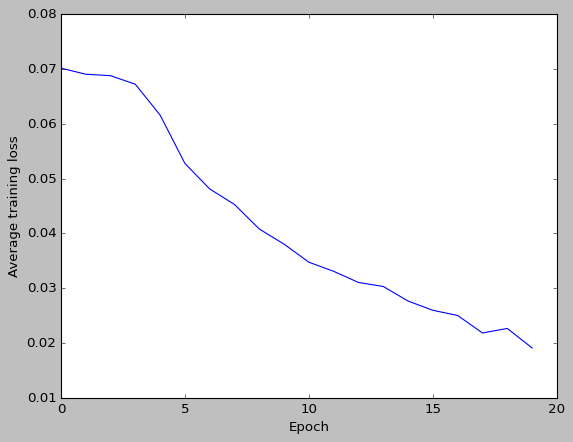

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

plt.plot(means_avg_training_losses)
plt.xlabel('Epoch')
plt.ylabel('Average training loss')
plt.savefig('avg training loss.png', dpi=200)


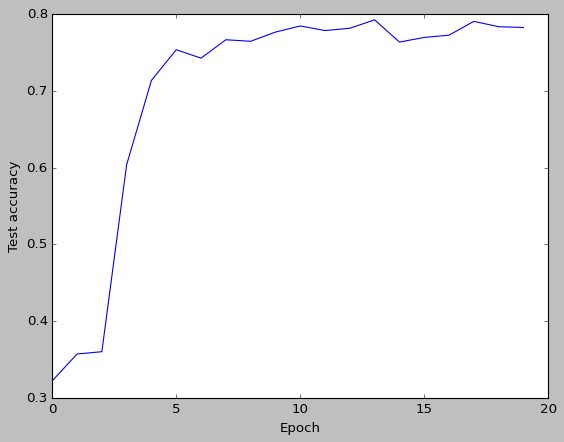

In [ ]:
plt.plot(accuracies)
plt.xlabel('Epoch')
plt.ylabel('Test accuracy')
plt.savefig('test accuracy.png', dpi=200)


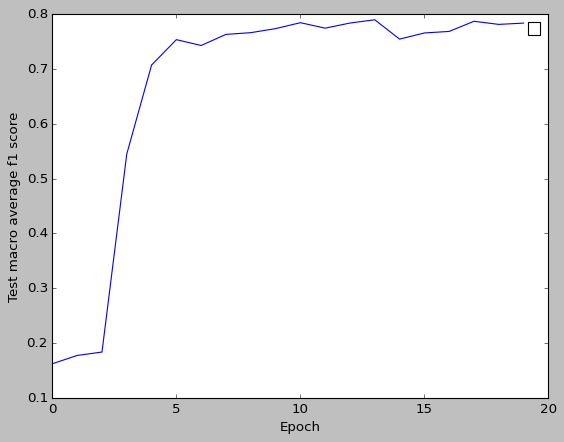

In [ ]:
plt.plot(macro_f1_scores)
plt.xlabel('Epoch')
plt.ylabel('Test macro average f1 score')
plt.legend()
plt.savefig('test macro avg f1.png', dpi=200)

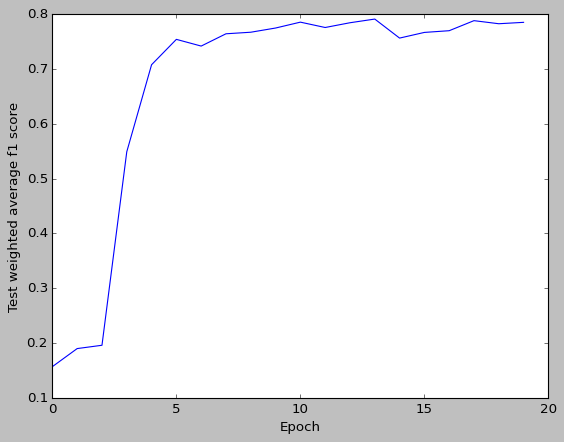

In [ ]:
plt.plot(weighted_f1_scores)
plt.xlabel('Epoch')
plt.ylabel('Test weighted average f1 score')
plt.savefig('test weighted avg f1.png', dpi=200)

In [ ]:
with open('log_post_train_info.pkl', 'rb') as f:
    post_train_info = pkl.load(f)
    pprint.pprint(post_train_info)

{'max_accuracy': 0.7924151696606786,
 'max_accuracy_index': 13,
 'max_macro_f1': 0.7867241653680782,
 'max_macro_f1_index': 17,
 'max_weighted_f1': 0.7847896835700771,
 'max_weighted_f1_index': 19}


In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
def prepare_xlmroberta_model():
    num_classes = 3
    input_dim = 768

    classifier_head = RobertaClassificationHead(num_classes=num_classes, input_dim=input_dim)
    model = XLMR_BASE_ENCODER.get_model(head=classifier_head)

    DEMO_MODEL_PATH = 'model_max_accuracy.pth'
    model.load_state_dict(torch.load(DEMO_MODEL_PATH))
    model.to(DEVICE)

    print(f'Loaded model to [{DEVICE}] in [{DEMO_MODEL_PATH}]')
    return model


In [ ]:
def prepare_text_transform():
    text_transform = torchtext.models.XLMR_LARGE_ENCODER.transform()
    return text_transform


In [ ]:
def predict_xlmRoberta(sentence, model, text_transform, label_map):
    transformed_text = text_transform(sentence)
    out = model(torch.tensor([transformed_text]).to(DEVICE))
    probabilities = torch.softmax(out, dim=1).squeeze().detach().cpu().numpy()
    predicted_label = label_map[torch.argmax(out).item()]
    return probabilities, predicted_label


In [ ]:
XLMmodel = prepare_xlmroberta_model()
text_transform = prepare_text_transform()


Loaded model to [cpu] in [model_max_weighted_f1.pth]


In [3]:
label_map = {
    0: 'positive',
    1: 'negative',
    2: 'neutral',
}

In [ ]:
sample_text = 'gồng lỗ vượt qua thời kì khó khăn đang là thách thức với các doanh nghiệp'

gồng lỗ vượt qua thời kì khó khăn đang là thách thức với các doanh nghiệp


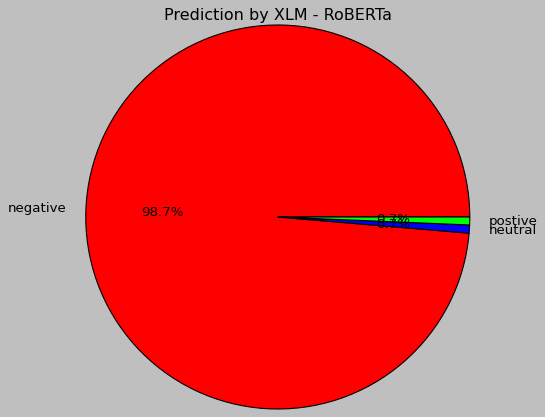

In [ ]:
probabilities, predicted_label = predict_xlmRoberta(sample_text, XLMmodel, text_transform, label_map)

colors = ['#FF0000', '#0000FF', '#00FF00']
percentages = probabilities * 100

print(sample_text)
plt.pie(percentages, labels=label_map.values(), autopct='%1.1f%%', colors=colors)
plt.axis('equal')
plt.title('Prediction by XLM - RoBERTa')
plt.show()